In [1]:
%matplotlib inline
import brine
import cv2
import numpy as np
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, Conv2DTranspose
from keras.layers.convolutional import UpSampling2D
from keras.layers import BatchNormalization, Activation, Input, concatenate
from keras.optimizers import RMSprop
from keras.losses import binary_crossentropy
import keras.backend as K

Using TensorFlow backend.


In [2]:
dataset = brine.load_dataset('dataset/images-and-masks')

In [3]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score


def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss


def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [9]:
import cv2
import numpy as np

def rndHueSatVal(image, hue_limit=(-180, 180), sat_limit=(-255, 255), val_limit=(-255, 255), u=0.5):
    if np.random.random() < u:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(image)
        hue_val = np.random.uniform(hue_limit[0], hue_limit[1])
        h = cv2.add(h, hue_val)
        sat_val = np.random.uniform(sat_limit[0], sat_limit[1])
        s = cv2.add(s, sat_val)
        val_val = np.random.uniform(val_limit[0], val_limit[1])
        v = cv2.add(v, val_val)
        image = cv2.merge((h, s, v))
        image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)

    return image


def rndMoveScaleRot(image, mask,
                           move_limit=(-0.0625, 0.0625),
                           scale_limit=(-0.1, 0.1),
                           rot_limit=(-45, 45), aspect_limit=(0, 0),
                           borderMode=cv2.BORDER_CONSTANT, u=0.5):
    if np.random.random() < u:
        height, width, channel = image.shape

        angle = np.random.uniform(rot_limit[0], rot_limit[1])  # degree
        scale = np.random.uniform(1 + scale_limit[0], 1 + scale_limit[1])
        aspect = np.random.uniform(1 + aspect_limit[0], 1 + aspect_limit[1])
        sx = scale * aspect / (aspect ** 0.5)
        sy = scale / (aspect ** 0.5)
        dx = round(np.random.uniform(move_limit[0], move_limit[1]) * width)
        dy = round(np.random.uniform(move_limit[0], move_limit[1]) * height)

        cc = np.math.cos(angle / 180 * np.math.pi) * sx
        ss = np.math.sin(angle / 180 * np.math.pi) * sy
        rotate_matrix = np.array([[cc, -ss], [ss, cc]])

        box0 = np.array([[0, 0], [width, 0], [width, height], [0, height], ])
        box1 = box0 - np.array([width / 2, height / 2])
        box1 = np.dot(box1, rotate_matrix.T) + np.array([width / 2 + dx, height / 2 + dy])

        box0 = box0.astype(np.float32)
        box1 = box1.astype(np.float32)
        mat = cv2.getPerspectiveTransform(box0, box1)
        image = cv2.warpPerspective(image, mat, (width, height), flags=cv2.INTER_LINEAR, 
                                    borderMode=borderMode, borderValue=(0, 0, 0,))
        mask = cv2.warpPerspective(mask, mat, (width, height), flags=cv2.INTER_LINEAR, 
                                   borderMode=borderMode, borderValue=(0, 0, 0,))

    return image, mask


def rndHorFlip(image, mask, u=0.5):
    if np.random.random() < u:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)

    return image, mask


In [4]:
inputs = Input(shape=(64, 64, 3))

down1 = Convolution2D(128, (3, 3), padding='same')(inputs)
down1 = BatchNormalization()(down1)
down1 = Activation('relu')(down1)
down1 = Convolution2D(128, (3, 3), padding='same')(down1)
down1 = BatchNormalization()(down1)
down1 = Activation('relu')(down1)
down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)

down2 = Convolution2D(256, (3, 3), padding='same')(down1_pool)
down2 = BatchNormalization()(down2)
down2 = Activation('relu')(down2)
down2 = Convolution2D(256, (3, 3), padding='same')(down2)
down2 = BatchNormalization()(down2)
down2 = Activation('relu')(down2)
down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)

down3 = Convolution2D(512, (3, 3), padding='same')(down2_pool)
down3 = BatchNormalization()(down3)
down3 = Activation('relu')(down3)
down3 = Convolution2D(512, (3, 3), padding='same')(down3)
down3 = BatchNormalization()(down3)
down3 = Activation('relu')(down3)
down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)

center = Convolution2D(1024, (3, 3), padding='same')(down3_pool)
center = BatchNormalization()(center)
center = Activation('relu')(center)
center = Convolution2D(1024, (3, 3), padding='same')(center)
center = BatchNormalization()(center)
center = Activation('relu')(center)

up3 = UpSampling2D((2, 2))(center)
up3 = concatenate([down3, up3], axis=3)
up3 = Convolution2D(512, (3, 3), padding='same')(up3)
up3 = BatchNormalization()(up3)
up3 = Activation('relu')(up3)
up3 = Convolution2D(512, (3, 3), padding='same')(up3)
up3 = BatchNormalization()(up3)
up3 = Activation('relu')(up3)
up3 = Convolution2D(512, (3, 3), padding='same')(up3)
up3 = BatchNormalization()(up3)
up3 = Activation('relu')(up3)

up2 = UpSampling2D((2, 2))(up3)
up2 = concatenate([down2, up2], axis=3)
up2 = Convolution2D(256, (3, 3), padding='same')(up2)
up2 = BatchNormalization()(up2)
up2 = Activation('relu')(up2)
up2 = Convolution2D(256, (3, 3), padding='same')(up2)
up2 = BatchNormalization()(up2)
up2 = Activation('relu')(up2)
up2 = Convolution2D(256, (3, 3), padding='same')(up2)
up2 = BatchNormalization()(up2)
up2 = Activation('relu')(up2)

up1 = UpSampling2D((2, 2))(up2)
up1 = concatenate([down1, up1], axis=3)
up1 = Convolution2D(128, (3, 3), padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Activation('relu')(up1)
up1 = Convolution2D(128, (3, 3), padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Activation('relu')(up1)
up1 = Convolution2D(128, (3, 3), padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Activation('relu')(up1)

masking = Convolution2D(1, (1, 1), activation='sigmoid')(up1)

model = Model(inputs=inputs, outputs=masking)

model.compile(optimizer=RMSprop(lr=0.0001), loss=bce_dice_loss, metrics=[dice_coeff])

In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 128)  3584        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 128)  512         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 64, 64, 128)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [6]:
SIZE = (64, 64)

# grayscale mask to bw
def gs2bw(mask):
    mask[mask < 100] = 0.0
    mask[mask >= 100] = 255.0
    
# training processing function
def trn_proc(data):
    img, mask = data
    img = img[:,:,:3]
    mask = mask[:, :, :3]
    gs2bw(mask)
    img = cv2.resize(img, SIZE)
    mask = cv2.resize(mask, SIZE)
    img = rndHueSatVal(img, hue_limit=(-50, 50), sat_limit=(0, 0), val_limit=(-15, 15))
    img, mask = rndMoveScaleRot(img, mask, move_limit=(-0.0625, 0.0625), scale_limit=(-0.1, 0.1),
                                       rot_limit=(-20, 20))
    img, mask = rndHorFlip(img, mask)
    gs2bw(mask)
    img = img/255.
    mask = mask/255.
    mask = np.expand_dims(mask, axis=2)
    return (img, mask)

# validation processing function
def val_proc(data):
    img, mask = data
    img = img[:,:,:3]
    mask = mask[:, :, :3]
    gs2bw(mask)
    img = cv2.resize(img, SIZE)
    mask = cv2.resize(mask, SIZE)
    gs2bw(mask)
    img = img/255.
    mask = mask/255.
    mask = np.expand_dims(mask, axis=2)
    return (img, mask)

In [7]:
BATCH_SIZE = 1

validation_fold, train_fold = dataset.create_folds((20,))
print('Validation size:', len(validation_fold))
print('Train size:', len(train_fold))

train_generator = train_fold.to_keras('image', 'mask', batch_size=BATCH_SIZE, shuffle=True, 
                                      processing_function=trn_proc)
validation_generator = validation_fold.to_keras('image', 'mask', batch_size=BATCH_SIZE, 
                                                shuffle=False, processing_function=val_proc)

Validation size: 20
Train size: 100


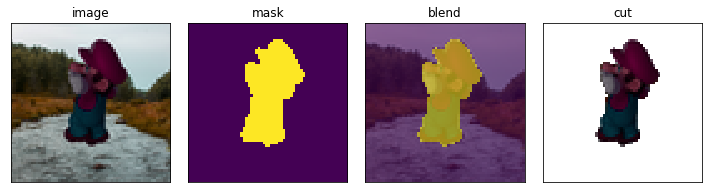

In [10]:
image, mask = next(train_generator)

def draw_image_mask(image, mask):
    mask[mask < 0.25] = 0
    mask[mask >= 0.25] = 1
    mask = mask.astype(int)
    msk_op = np.expand_dims(mask, axis=2)
    blended = msk_op * image + (1. - msk_op) * np.ones((64, 64, 3))
    f = plt.figure(figsize=(10,10))
    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.title("image")
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 4, 2)
    plt.imshow(mask)
    plt.title("mask")
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 4, 3)
    plt.title("blend")
    plt.imshow(image)
    plt.imshow(mask, alpha=0.6)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 4, 4)
    plt.imshow(blended)
    plt.title("cut")
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

draw_image_mask(image[0], mask[0].reshape(SIZE))

In [23]:
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               min_delta=1e-4),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/best_weights.hdf5',
                             save_best_only=True,
                             save_weights_only=True)]

In [26]:
epochs=100
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_generator.steps_per_epoch(),
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.steps_per_epoch())

Epoch 1/100
100/100 [==============================] - 201s 2s/step - loss: 0.3535 - dice_coeff: 0.8008 - val_loss: 0.3435 - val_dice_coeff: 0.8323
Epoch 2/100
100/100 [==============================] - 193s 2s/step - loss: 0.2023 - dice_coeff: 0.8845 - val_loss: 0.3751 - val_dice_coeff: 0.8133
Epoch 3/100
100/100 [==============================] - 183s 2s/step - loss: 0.1377 - dice_coeff: 0.9188 - val_loss: 0.5812 - val_dice_coeff: 0.8054
Epoch 4/100
100/100 [==============================] - 171s 2s/step - loss: 0.1269 - dice_coeff: 0.9294 - val_loss: 0.1925 - val_dice_coeff: 0.8983
Epoch 5/100
100/100 [==============================] - 172s 2s/step - loss: 0.1000 - dice_coeff: 0.9427 - val_loss: 0.0882 - val_dice_coeff: 0.9446
Epoch 6/100
100/100 [==============================] - 180s 2s/step - loss: 0.1000 - dice_coeff: 0.9435 - val_loss: 0.1912 - val_dice_coeff: 0.9056
Epoch 7/100
100/100 [==============================] - 172s 2s/step - loss: 0.0764 - dice_coeff: 0.9561 - val_lo

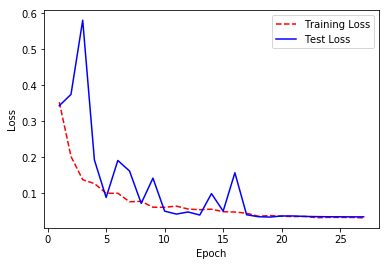

In [28]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [11]:
model.load_weights('weights/best_weights.hdf5')

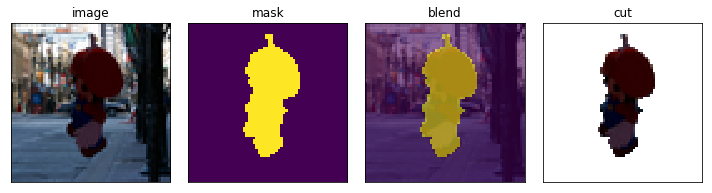

In [12]:
image_batch, mask_batch = next(validation_generator)
predicted_mask_batch = model.predict(image_batch)
draw_image_mask(image_batch[0], predicted_mask_batch[0].reshape(SIZE))

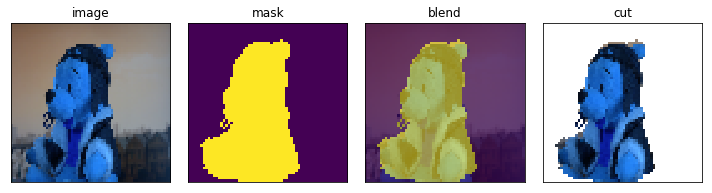

In [15]:
image = cv2.imread('alphamatting.com/GT05.png')
image = image[:,:,:3]
image = cv2.resize(image, SIZE)
image = image/255.
image_batch = np.array([image])
predicted_mask_batch = model.predict(image_batch)
draw_image_mask(image_batch[0], predicted_mask_batch[0].reshape(SIZE))

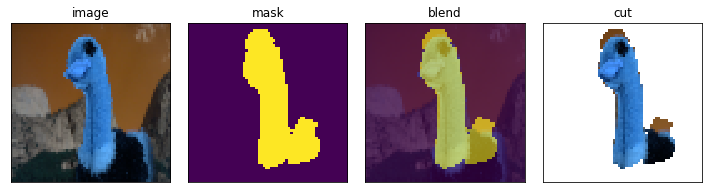

In [16]:
image = cv2.imread('alphamatting.com/GT14.png')
image = image[:,:,:3]
image = cv2.resize(image, SIZE)
image = image/255.
image_batch = np.array([image])
predicted_mask_batch = model.predict(image_batch)
draw_image_mask(image_batch[0], predicted_mask_batch[0].reshape(SIZE))

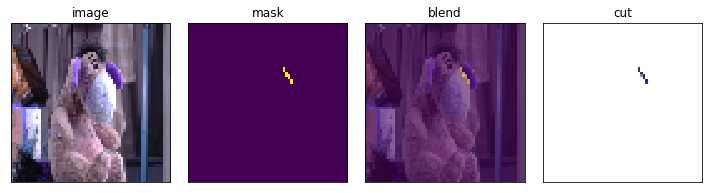

In [17]:
image = cv2.imread('alphamatting.com/GT24.png')
image = image[:,:,:3]
image = cv2.resize(image, SIZE)
image = image/255.
image_batch = np.array([image])
predicted_mask_batch = model.predict(image_batch)
draw_image_mask(image_batch[0], predicted_mask_batch[0].reshape(SIZE))